# Summary

In this Notebook I look at both theoretical and live returns for levered indices.

* The price series of levered returns do not usually match the corresponding price series of unlevered returns but in expecatation the total return of the levered price series should match the amount of leverage multiplied by the total return of the unlevered price series. Assuming prices follow Geometric Brownian Motion, the total return of an unlevered price series is $e^{\mu t}$ while the total return of the levered price series is $e^{leverage*\mu t}$.

* Looking at live returns of ETFs versus leveraged returns of the indices that they track, we see that the daily returns and annual returns closely match what they track.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

# Simulate Daily Returns

Let's simulate daily returns and compound them a full year. 

At the end of the year, we will calculate the continously compounded return and the daily compounded return and compare it to the return we simulated.

If securities follow the GBM Stochastic Process $dS_t = \mu S_t dt + \sigma S_t dB_t$ where changes in security prices are normally distributed.

$$S_t = S_0\exp\{{(\mu-\frac{\sigma^2}{2})t + \sigma B_t}\}$$

$$B_t \sim \ N(0,t)$$

$$E[S_t] = S_0 \exp\{{(\mu-\frac{\sigma^2}{2})t}\} E[\exp\{{\sigma B_t}\}]$$

The expectation of the lognormal random variable $E[\exp\{{\sigma B_t}\}]$ is $\exp{\frac{\sigma^2}{2} t}$

$$E[S_t] = S_0 \exp\{{(\mu-\frac{\sigma^2}{2})t + \frac{\sigma^2}{2} t}\}$$

$$E[S_t] = S_0 \exp\{\mu t\}$$


https://en.wikipedia.org/wiki/Geometric_Brownian_motion#Properties_of_GBM


Let's see what the theoretical variance of GBM should be.

$$E[S_t^2] = S_0^2 \exp\{{2(\mu-\frac{\sigma^2}{2})t}\} E[\exp\{{2\sigma B_t}\}]$$

$$E[S_t^2] = S_0^2 \exp\{{(2 \mu + \sigma^2)t} \} $$

$$V[S_t] = E[S_t^2] - E[S_t]^2 =  S_0^2 [\exp\{(2 \mu + \sigma^2)t\} - \exp\{2 \mu t\} ]$$

$$V[S_t] = S_0^2 \exp\{2 \mu t\} [\exp\{\sigma^2t\} -  1]$$

$\sigma_d$ is the daily volatility and $\sigma_a$ is the annual volatility

$t_d$ is the number of days in a year

$\mu_d$ is the daily return and $\mu_a$ is the annual return

$$\sigma_d^2 t_d = \sigma_a^2 \rightarrow \sigma_d = \frac{\sigma_a}{\sqrt{t_d}}$$

$$\mu_d t_d = \mu_a \rightarrow \mu_d = \frac{\mu_a}{t_d} $$

In [3]:
sigma_a = 0.1
sharpe = 0.3
mu_a = sigma_a*sharpe

days_in_year = 252
trials = 10000

In [4]:
sigma_d = sigma_a/np.sqrt(days_in_year)
mu_d = mu_a/days_in_year

Here I will use the GBM Proces $dS_t = \mu S_t dt + \sigma S_t dB_t$.

$$E[S_t] = S_0 \exp\{\mu t\}$$

$$V[S_t] = S_0^2 \exp\{2 \mu t\} [\exp\{\sigma^2t\} -  1]$$

In [5]:
seed=0
np.random.seed(seed)
rets = np.random.normal(
    loc=mu_d - sigma_d**2/2,
    scale=sigma_d,
    size=days_in_year*trials
).reshape(
    days_in_year,
    trials
)

In [6]:
S_0 = 100
#to avoid numerical instability in a product I switched it to a sum
S_t = S_0*np.exp(np.cumsum(rets,axis=0))

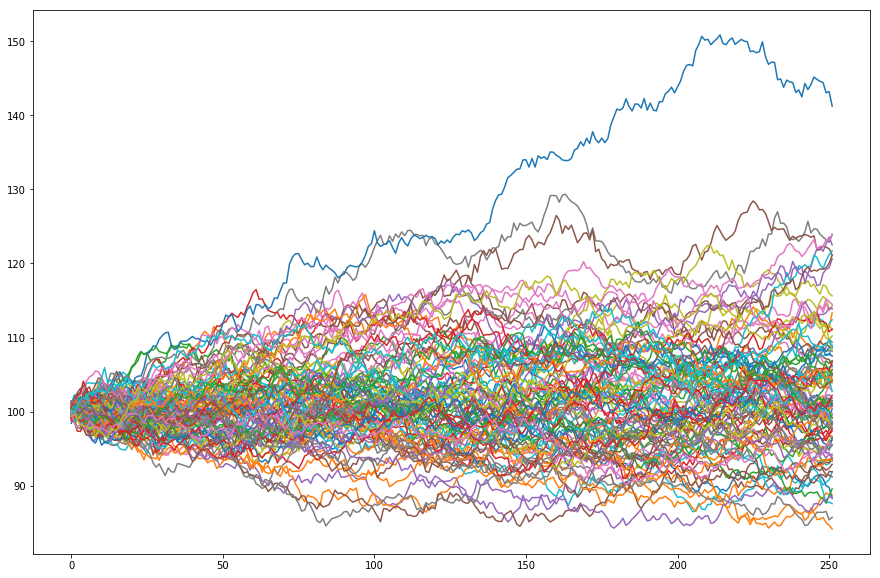

In [7]:
plt.plot(S_t[:,:100])
plt.show()

In [8]:
expected_total_return = S_0*np.exp(mu_d*days_in_year)
print("Expected Return: %f" % expected_total_return)

realized_total_return = np.mean(S_t[-1,:])
print("Realized Return: %f" % realized_total_return)

error = realized_total_return - expected_total_return
print("Error:\t\t %f" % error)

variance = np.sqrt(
    (S_0**2)*
    np.exp(
        2*mu_d*days_in_year
    )*
    (
        np.exp(sigma_d**2*days_in_year) -
        1
    )
)

print(np.sqrt(variance))

tvalue = error/(np.sqrt(variance)/np.sqrt(trials))
print("T Statistic:\t %f" % tvalue)

print("P Value:\t %f" % (stats.norm.cdf(-np.abs(tvalue))*2))

Expected Return: 103.045453
Realized Return: 103.078549
Error:		 0.033095
3.21408781040338
T Statistic:	 1.029691
P Value:	 0.303155


We expect some error due to the difference in daily compounding and continously compounding.

# Levered Returns

Now let's see if our levered annual return is 3x our annual return.

$dS_t = \mu S_t dt + \sigma S_t dB_t$ becomes $dS_{t,levered} = 3\mu S_t dt + 3\sigma S_t dB_t$

Let $\mu_{L} = 3\mu$ and $\sigma_{L} = 3 \sigma$.

$$S_{t,levered} = S_0\exp\{(\mu_{L}-\frac{\sigma_{L}^2}{2})t + B_t\sigma_{L}\}$$

$$S_{t,levered} = S_0\exp\{(3\mu-\frac{9\sigma^2}{2})t + 3 B_t\sigma\}$$

$$E[S_{t,levered}] = S_0 \exp\{\mu_{L} t\}$$

$$E[S_{t,levered}] = S_0 \exp\{3\mu t\}$$

$$V[S_{t,levered}] = S_0^2 \exp\{2 \mu_{L} t\} [\exp\{\sigma_{L}^2 t\} -  1]$$

$$V[S_{t,levered}] = S_0^2 \exp\{6 \mu t\} [\exp\{9 \sigma^2 t\} -  1]$$


In [9]:
seed=0
np.random.seed(seed)
levered_rets = np.random.normal(
    loc=3*mu_d - 9*sigma_d**2/2,
    scale=3*sigma_d,
    size=days_in_year*trials
).reshape(
    days_in_year,
    trials
)

In [10]:
S_0 = 100
#to avoid numerical instability in a product I switched it to a sum
S_t_levered = S_0*np.exp(np.cumsum(levered_rets,axis=0))

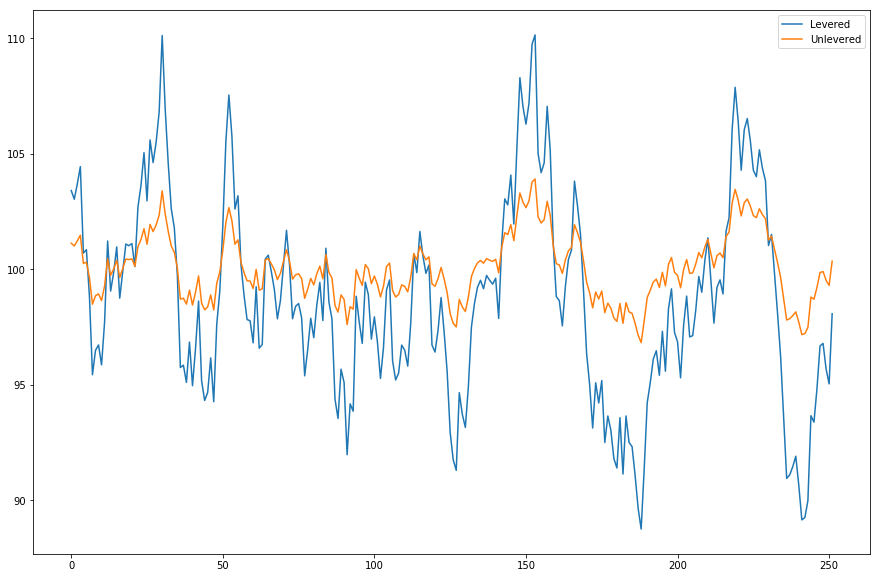

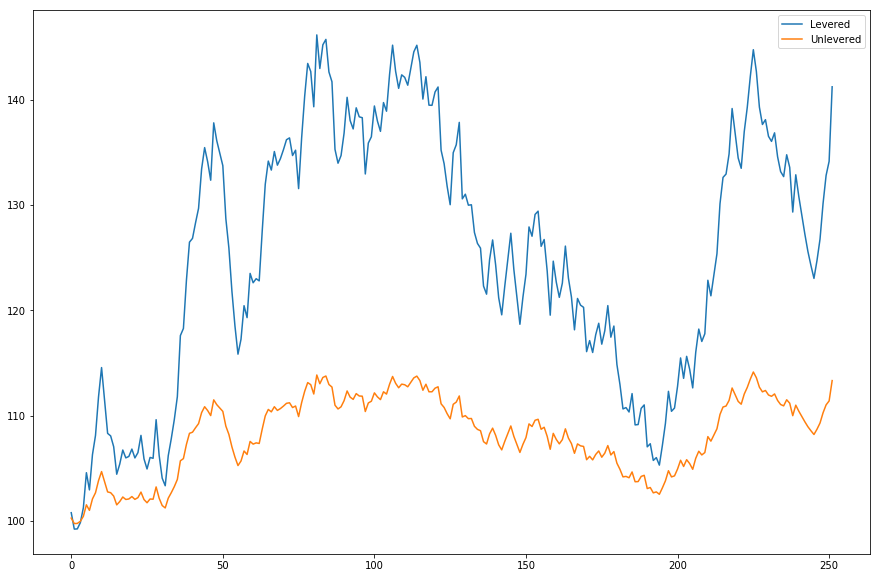

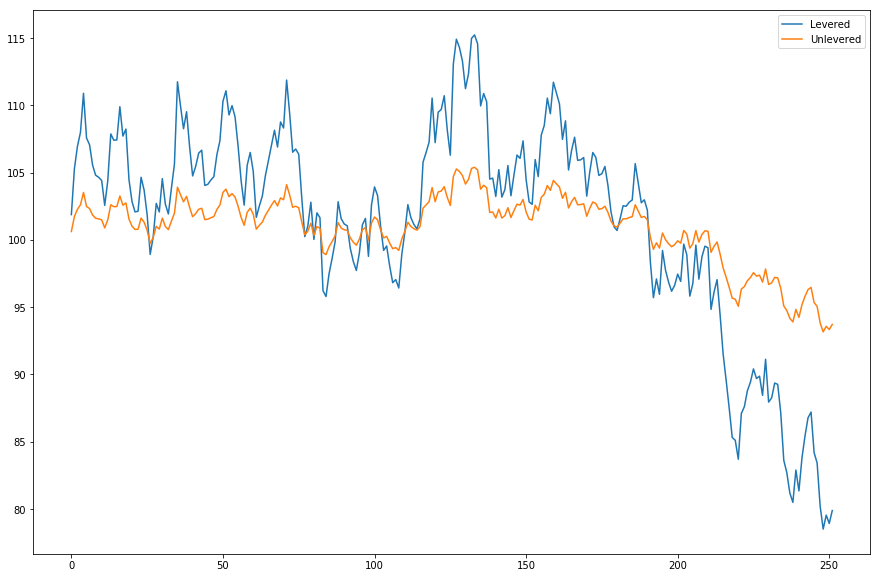

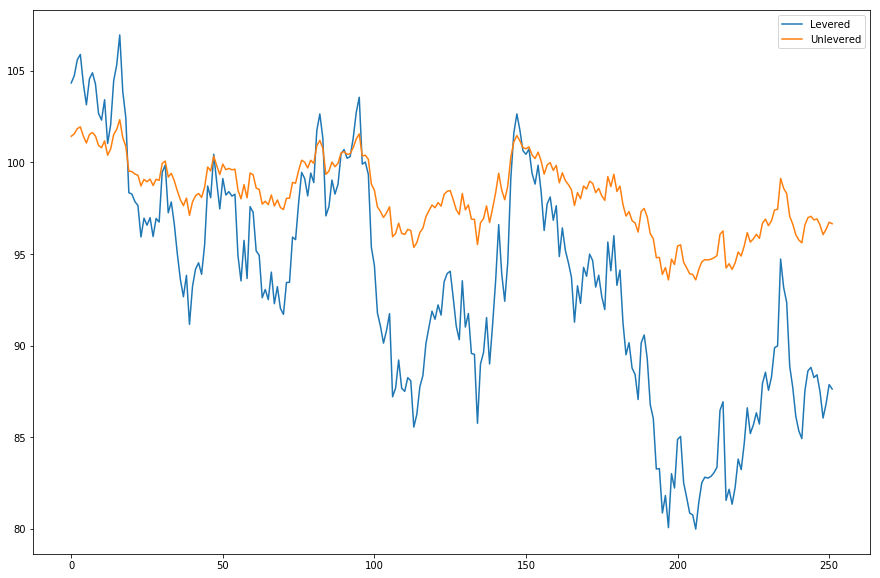

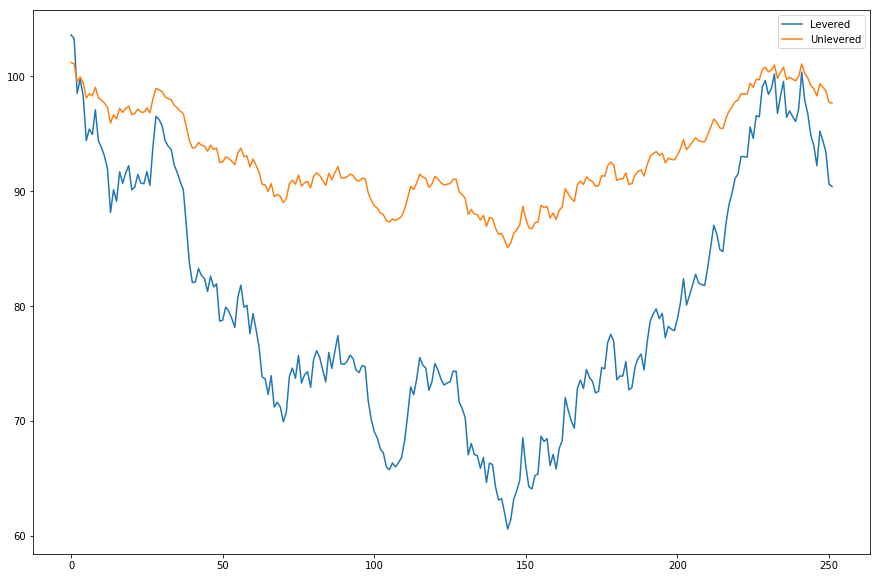

In [11]:
for i in range(5):
    plt.plot(S_t_levered[:,i],label='Levered')
    plt.plot(S_t[:,i],label='Unlevered')
    plt.legend()
    plt.show()

In [12]:
expected_total_return = S_0*np.exp(3*mu_d*days_in_year)
print("Expected Return: %f" % expected_total_return)

realized_total_return = np.mean(S_t_levered[-1,:])
print("Realized Return: %f" % realized_total_return)

error = realized_total_return - expected_total_return
print("Error:\t\t %f" % error)

variance = np.sqrt(
    (S_0**2)*
    np.exp(
        6*mu_d*days_in_year
    )*
    (
        np.exp(9*sigma_d**2*days_in_year) -
        1
    )
)

print(np.sqrt(variance))

tvalue = error/(np.sqrt(variance)/np.sqrt(trials))
print("T Statistic:\t %f" % tvalue)

print("P Value:\t %f" % (stats.norm.cdf(-np.abs(tvalue))*2))

Expected Return: 109.417428
Realized Return: 109.449059
Error:		 0.031631
5.794638306770972
T Statistic:	 0.545865
P Value:	 0.585159


As you can see above the levered instruments can have wildly varying ending prices due to compounding but the average total return is still 3x the return of the unlevered portfolio as we would expect.

Looking at our simulated prices series we can confirm these results.

In [13]:
print("Mean Levered Return: %0.2f%%" % (100*(np.mean(S_t_levered[-1,:])/S_0 - 1)))
print("Mean unlevered Return: %0.2f%%" % (100*(np.mean(S_t[-1,:])/S_0 - 1)))

Mean Levered Return: 9.45%
Mean unlevered Return: 3.08%


You can also see the difference in total returns over the year for both simulated price series.

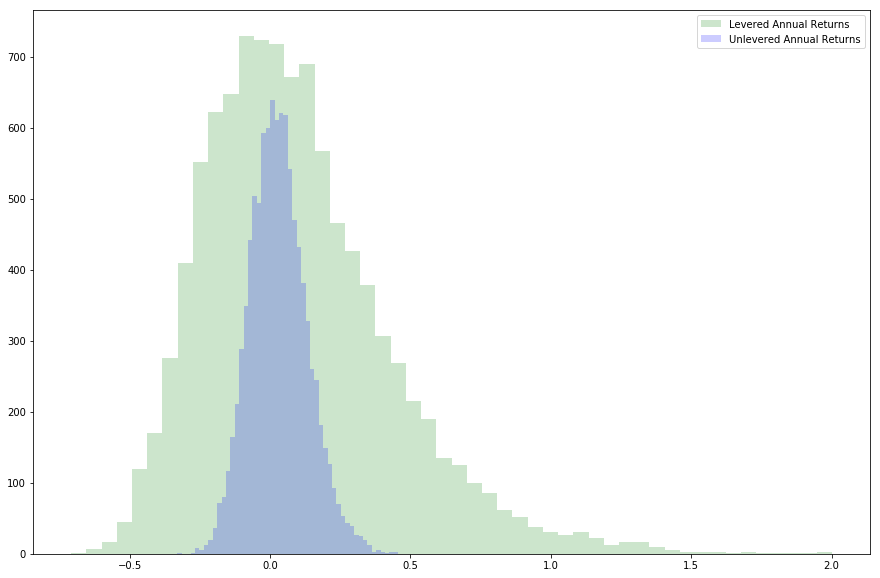

In [14]:
plt.hist(S_t_levered[-1,:]/S_0 - 1,bins=50,color='green',alpha=0.2,label='Levered Annual Returns')
plt.hist(S_t[-1,:]/S_0 - 1,bins=50,color='blue',alpha=0.2,label='Unlevered Annual Returns')
plt.legend()
plt.show()

Another way you can think about this is if you equally invested $\frac{1}{trials}$ into each security. To be clear, $trials$ represents the number of trials or securities in this portfolio.

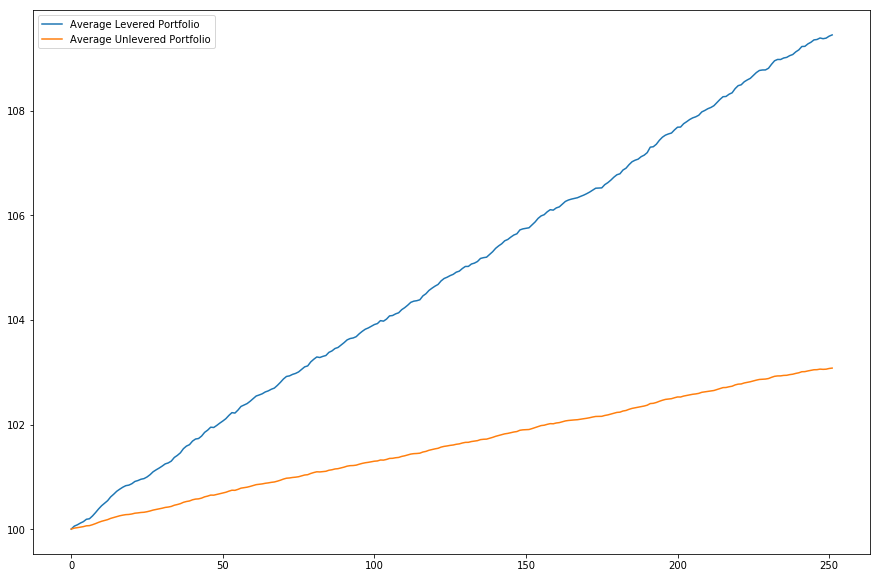

In [15]:
avg_levered_s = S_t_levered@np.ones((trials,1))/trials
avg_unlevered_s = S_t@np.ones((trials,1))/trials
plt.plot(avg_levered_s,label='Average Levered Portfolio')
plt.plot(avg_unlevered_s,label='Average Unlevered Portfolio')
plt.legend()
plt.show()

Below you can see the average annualized returns over time for both levered and unlevere returns. As time goes on both portfolios approximately return the theoretical expected returns.

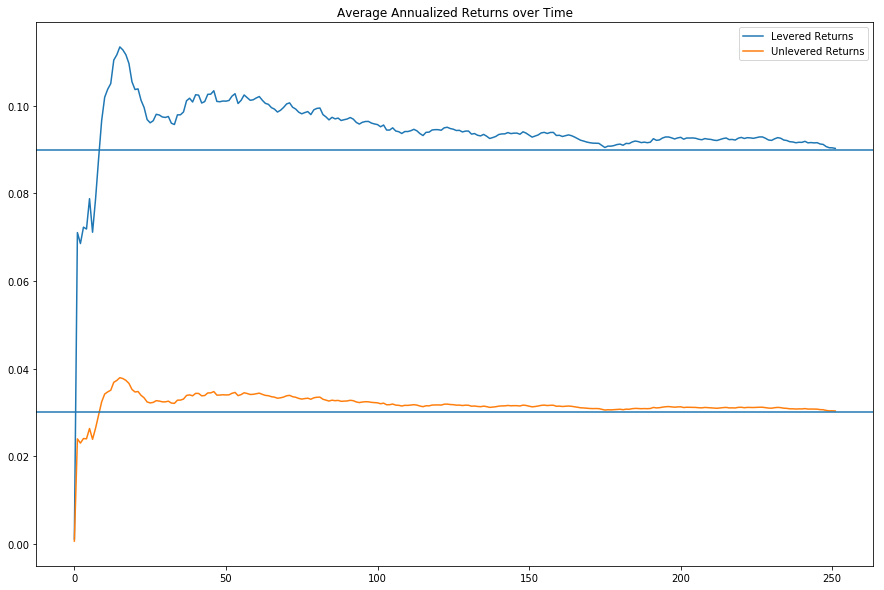

In [16]:
plt.plot(np.log(avg_levered_s/S_0)[:,0]*days_in_year/np.arange(1,1+days_in_year), label='Levered Returns')
plt.plot(np.log(avg_unlevered_s/S_0)[:,0]*days_in_year/np.arange(1,1+days_in_year), label='Unlevered Returns')
plt.title('Average Annualized Returns over Time')

plt.axhline(mu_a)
plt.axhline(3*mu_a)
plt.legend()
plt.show()

# Live Returns of Levered ETFs

In [17]:
levered_etfs = [
    ('SPXU US Equity','SPX Index',-3),
    ('SDS US Equity','SPX Index',-2),
    ('SH US Equity','SPX Index',-1),
    ('SSO US Equity','SPX Index',2),
    ('UPRO US Equity','SPX Index',3),
    
    ('SQQQ US Equity','NDX Index',-3),
    ('QID US Equity','NDX Index',-2),
    ('PSQ US Equity','NDX Index',-1),
    ('QLD US Equity','NDX Index',2),
    ('TQQQ US Equity','NDX Index',3),
    
    ('EFU US Equity','MXEA Index',-2),
    ('EFZ US Equity','MXEA Index',-1),
    ('EFO US Equity','MXEA Index',2),
    
    ('EEV US Equity','MXEF Index',-2),
    ('EUM US Equity','MXEF Index',-1),
    ('EET US Equity','MXEF Index',2),
    
    ('PST US Equity','IDCOT7TR Index',-2),
    ('TBX US Equity','IDCOT7TR Index',-1),
    ('UST US Equity','IDCOT7TR Index',2)
]
levered_etfs_df = pd.DataFrame(levered_etfs,columns=['ETF','Index','Leverage'])

In [18]:
#needs blpapi to be installed and a connection to a Bloomberg Terminal
import pdblp

con = pdblp.BCon(port=8194)
con.start()

In [19]:
historical_tickers = [x for x in levered_etfs_df['ETF'].values]
flds = ['PX_LAST']
startDate = 20071231
pdf_etf = con.bdh(historical_tickers, flds, startDate, '',elms=[("UseDPDF","N"), ("CshAdjNormal","Y"),("CshAdjAbnormal","Y"),("CapChg","Y")])
# remove multiindex
pdf_etf.columns = pdf_etf.columns.droplevel(1)

pdf_etf = pdf_etf.dropna()
pdf_etf.head()

ticker,QLD US Equity,SPXU US Equity,TQQQ US Equity,SDS US Equity,EFU US Equity,SH US Equity,PST US Equity,EFZ US Equity,SSO US Equity,TBX US Equity,EFO US Equity,UPRO US Equity,UST US Equity,EEV US Equity,SQQQ US Equity,EUM US Equity,QID US Equity,EET US Equity,PSQ US Equity
date,,,,,,,,,,,,,,,,,,,
2011-04-04,11.0802,1238.9832,3.5181,327.7660,95.1170,81.2423,41.8747,47.4041,25.9432,39.8272,30.4093,6.6604,37.0338,139.5730,1618.0293,28.8202,810.5943,117.92,129.5673
2011-04-07,11.0604,1236.6142,3.5035,326.8169,94.9011,81.1828,42.6327,47.3442,25.9770,40.2952,30.4380,6.6687,36.3951,138.7244,1621.8215,28.7635,811.7017,118.35,129.6467
2011-04-08,10.9527,1249.2489,3.4510,329.5061,93.3977,81.4605,42.8620,46.9746,25.7697,40.3519,31.0133,6.6085,36.2159,138.4748,1646.4712,28.7504,819.7696,118.68,130.2820
2011-04-11,10.8796,1261.0938,3.4198,331.2462,93.7176,81.7182,42.7723,47.0461,25.6300,40.6516,31.1667,6.5451,36.2619,141.6197,1661.0082,29.0397,824.9901,115.84,130.6791
2011-04-12,10.7348,1287.9424,3.3523,336.4664,95.4768,82.3528,42.2338,47.4641,25.2324,40.0622,30.6000,6.4001,36.7489,147.1108,1693.2424,29.5684,836.0638,111.51,131.5527


In [20]:
historical_tickers = list(set([x for x in levered_etfs_df['Index'].values]))
flds = ['PX_LAST']
startDate = 20071231
pdf_indices = con.bdh(historical_tickers, flds, startDate, '',elms=[("UseDPDF","N"), ("CshAdjNormal","Y"),("CshAdjAbnormal","Y"),("CapChg","Y")])
# remove multiindex
pdf_indices.columns = pdf_indices.columns.droplevel(1)

pdf_indices = pdf_indices.dropna()
pdf_indices.head()

ticker,IDCOT7TR Index,MXEF Index,SPX Index,MXEA Index,NDX Index
date,,,,,
2007-12-31,65.8410,1245.59,1468.36,2253.36,2084.93
2008-01-02,66.4579,1235.23,1447.16,2253.22,2049.71
2008-01-03,66.4600,1227.51,1447.16,2247.46,2051.76
2008-01-04,66.7391,1225.03,1411.63,2208.96,1963.52
2008-01-07,66.8559,1207.47,1416.18,2188.03,1957.44


In [21]:
pdf_indices = pdf_indices.reindex(pdf_etf.index)

In [22]:
levered_etfs_df['ETF Percent Mean'] = np.nan
levered_etfs_df['ETF Percent SD'] = np.nan

levered_etfs_df['Index Percent Mean'] = np.nan
levered_etfs_df['Index Percent SD'] = np.nan


for i in levered_etfs_df.index:
    etf = levered_etfs_df.loc[i,'ETF']
    index = levered_etfs_df.loc[i,'Index']
    
    temp_etf = pdf_etf[etf].pct_change()
    levered_etfs_df.loc[i,'ETF Percent Mean'] = np.mean(temp_etf)
    levered_etfs_df.loc[i,'ETF Percent SD'] = np.std(temp_etf,ddof=1)
    
    temp_index = pdf_indices[index].pct_change()
    levered_etfs_df.loc[i,'Index Percent Mean'] = np.mean(temp_index)
    levered_etfs_df.loc[i,'Index Percent SD'] = np.std(temp_index,ddof=1)
    
levered_etfs_df

,ETF,Index,Leverage,ETF Percent Mean,ETF Percent SD,Index Percent Mean,Index Percent SD
0,SPXU US Equity,SPX Index,-3,-0.001934,0.031794,0.000570,0.010615
1,SDS US Equity,SPX Index,-2,-0.001301,0.021177,0.000570,0.010615
2,SH US Equity,SPX Index,-1,-0.000666,0.010586,0.000570,0.010615
3,SSO US Equity,SPX Index,2,0.001258,0.021071,0.000570,0.010615
4,UPRO US Equity,SPX Index,3,0.001890,0.031573,0.000570,0.010615
5,SQQQ US Equity,NDX Index,-3,-0.002639,0.037028,0.000851,0.012423
6,QID US Equity,NDX Index,-2,-0.001777,0.024655,0.000851,0.012423
7,PSQ US Equity,NDX Index,-1,-0.000906,0.012351,0.000851,0.012423
8,QLD US Equity,NDX Index,2,0.001722,0.024546,0.000851,0.012423
9,TQQQ US Equity,NDX Index,3,0.002589,0.036665,0.000851,0.012423


### Levered ETFs Price Series vs. Levered Index Price Series

Looking below, we can see the ETFs are fairly similar to the levered indices over several years which is surprising. 

Leverage: -3


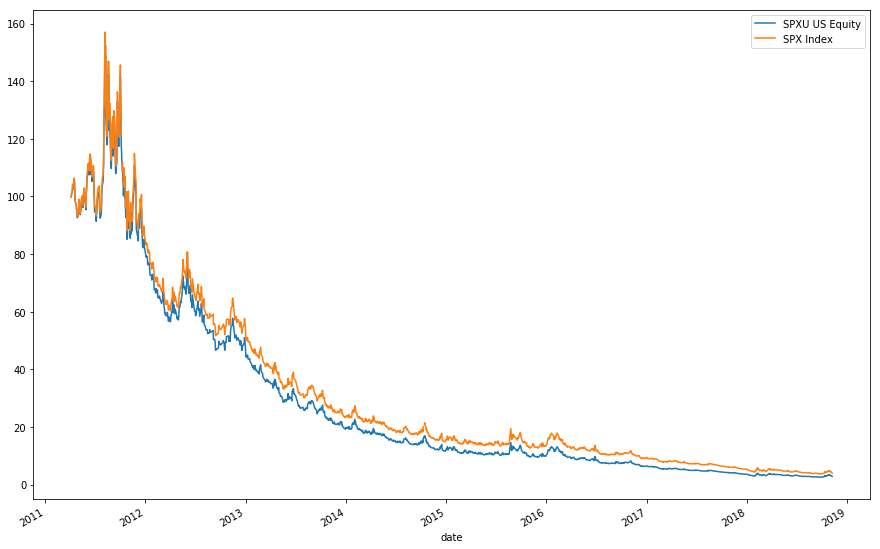

Leverage: -2


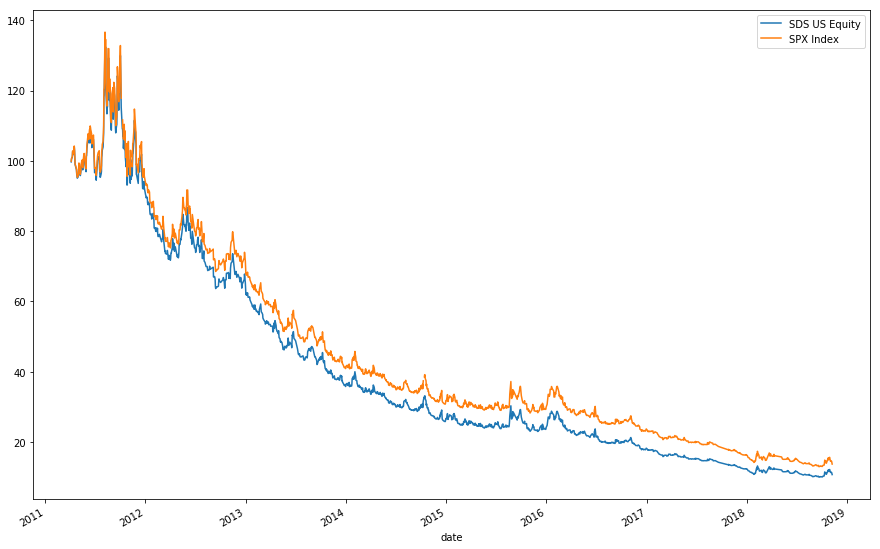

Leverage: -1


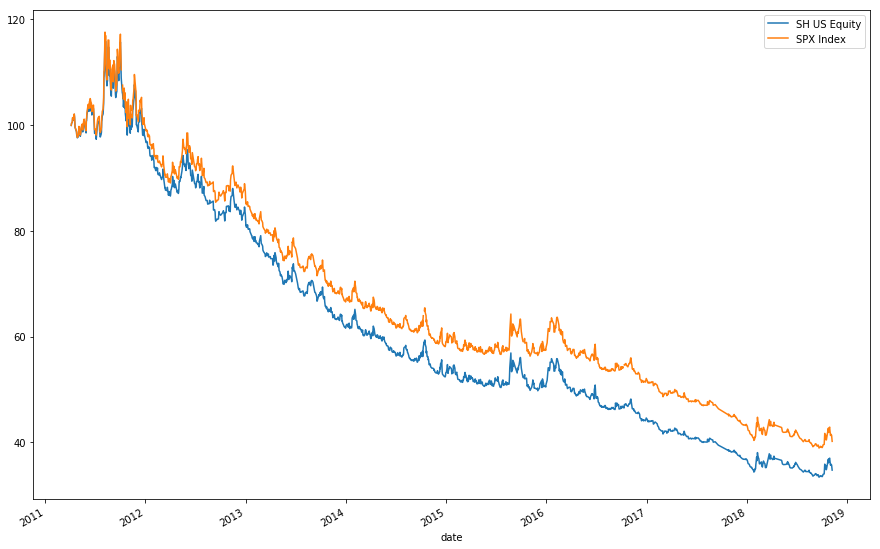

Leverage: 2


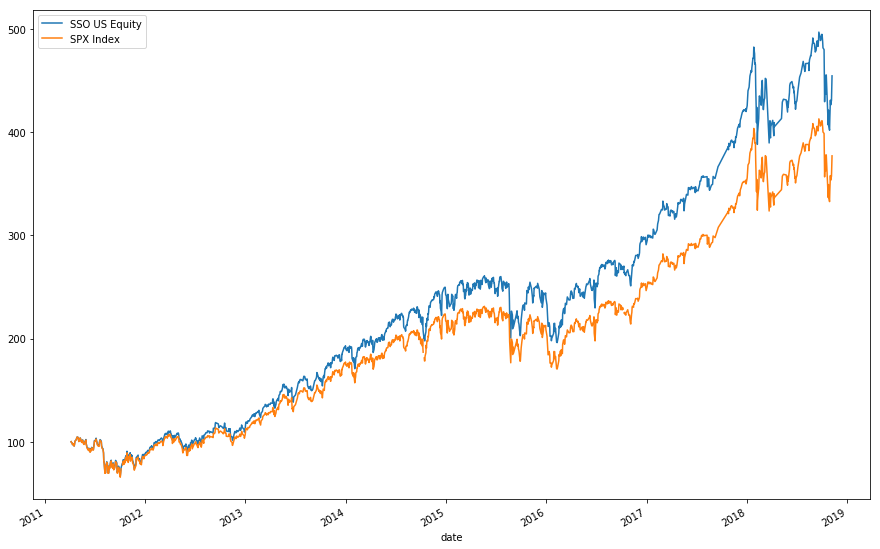

Leverage: 3


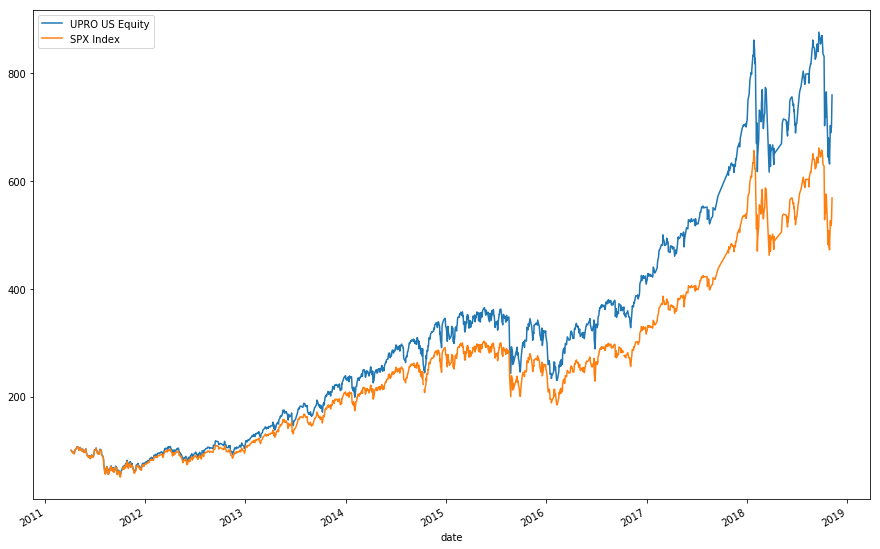

Leverage: -3


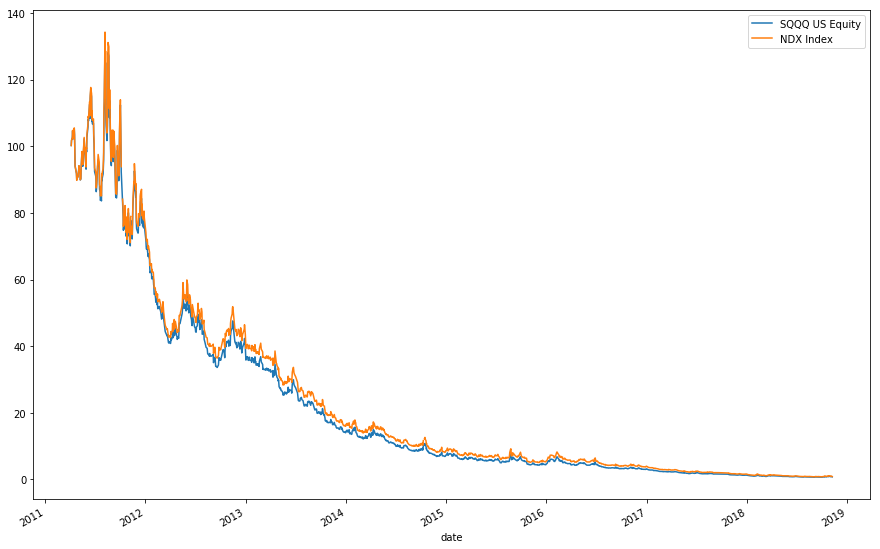

Leverage: -2


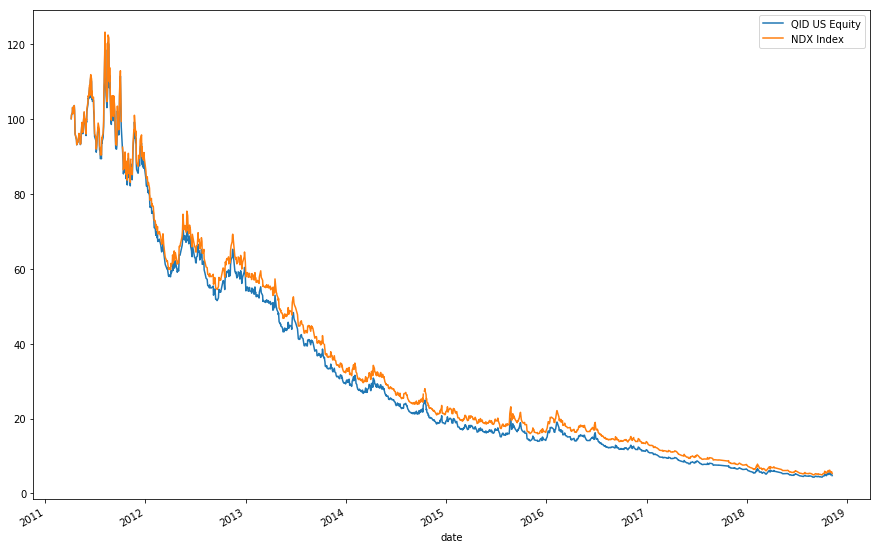

Leverage: -1


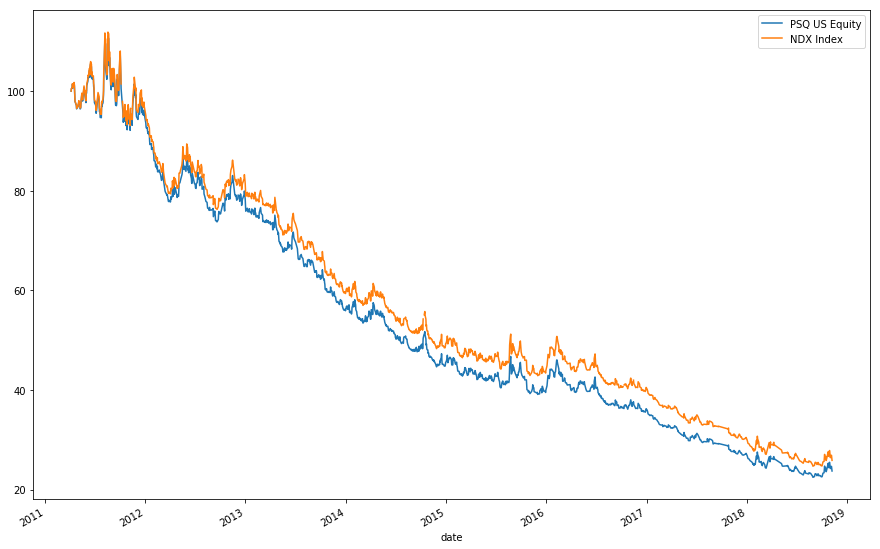

Leverage: 2


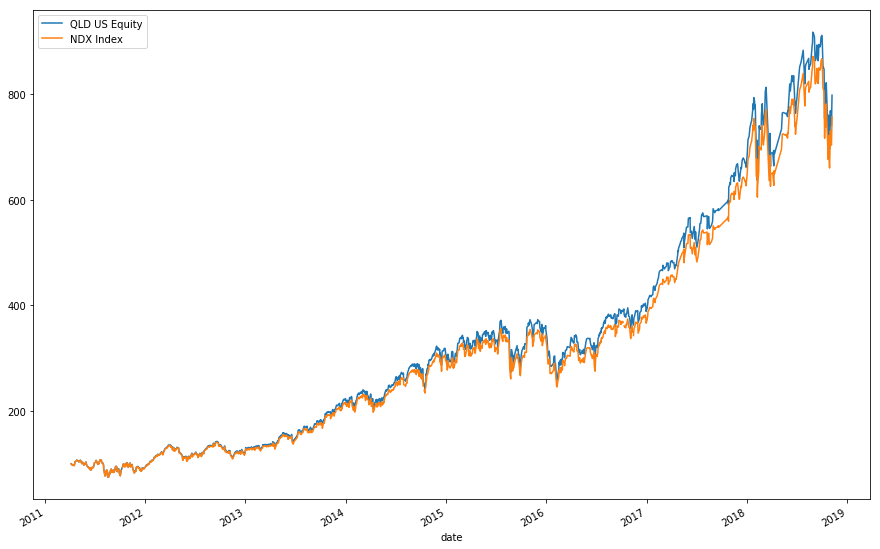

Leverage: 3


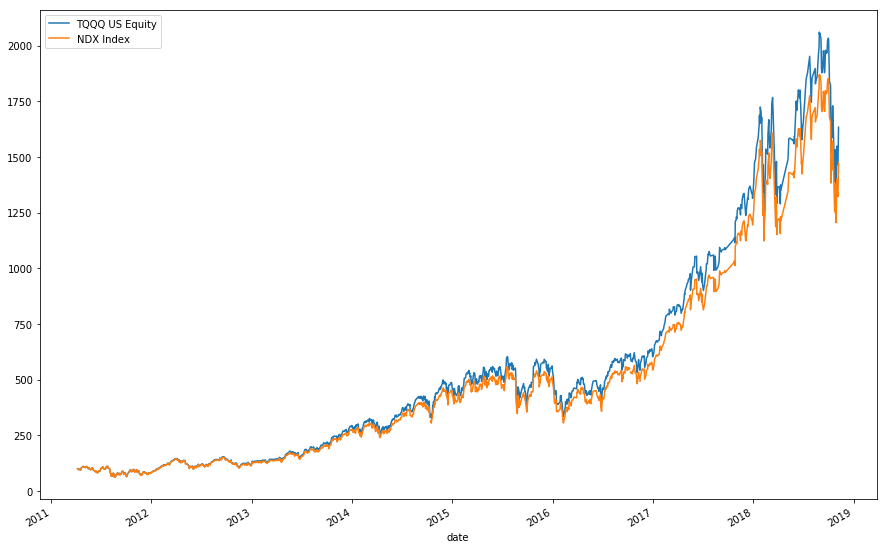

Leverage: -2


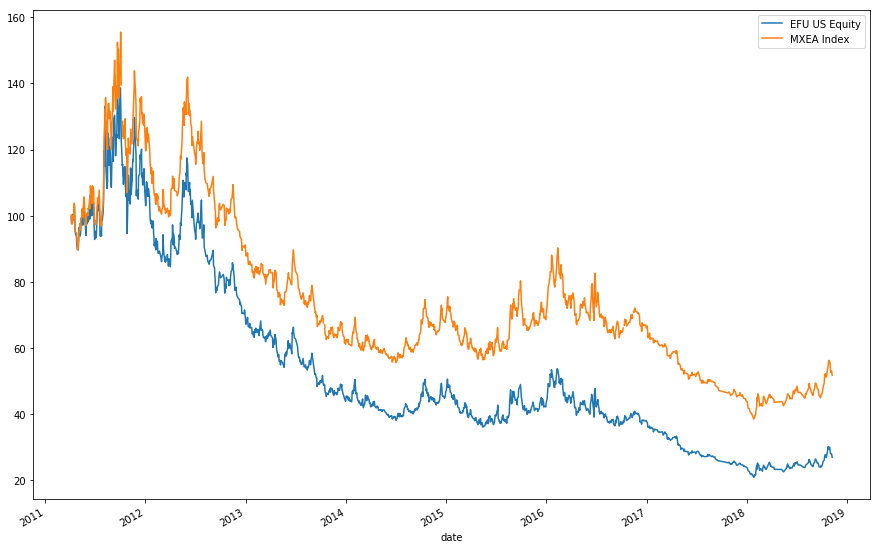

Leverage: -1


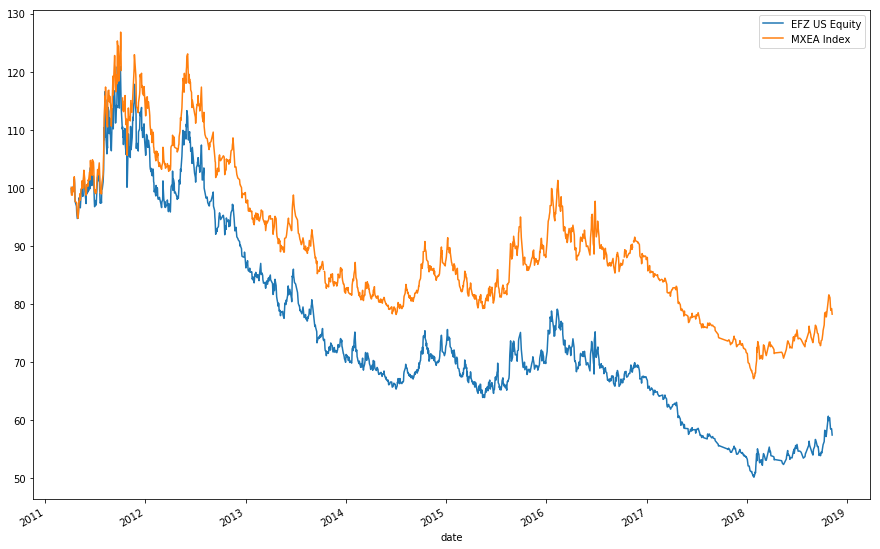

Leverage: 2


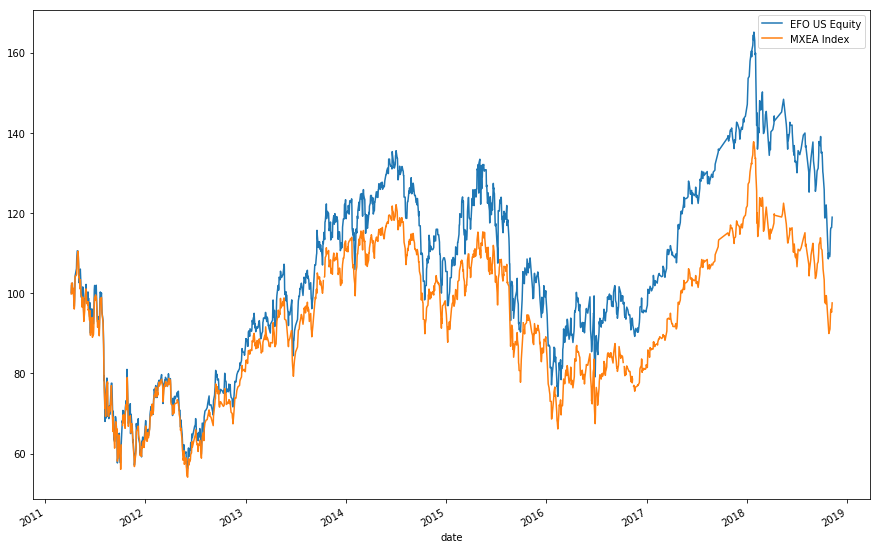

Leverage: -2


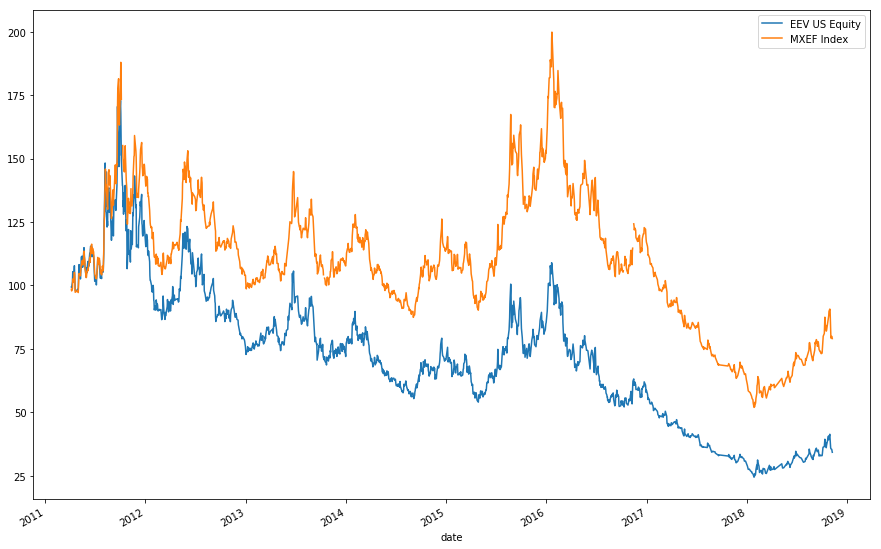

Leverage: -1


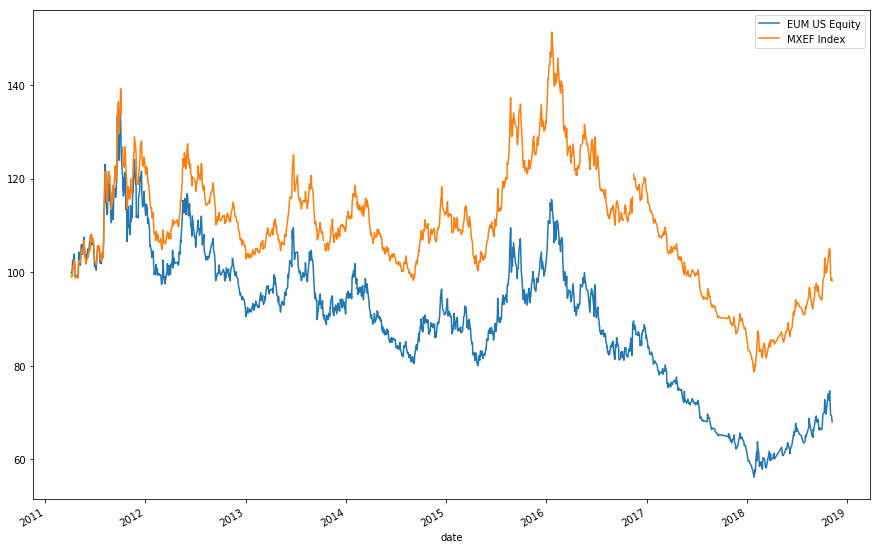

Leverage: 2


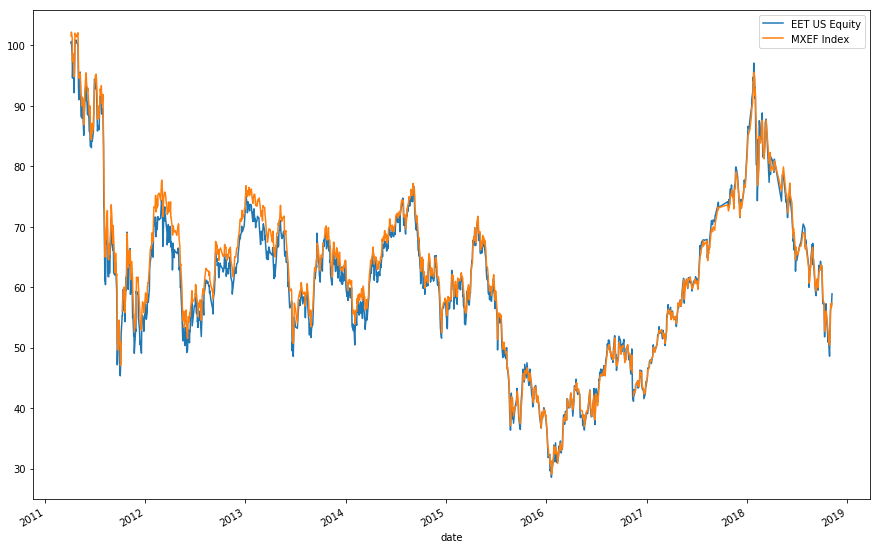

Leverage: -2


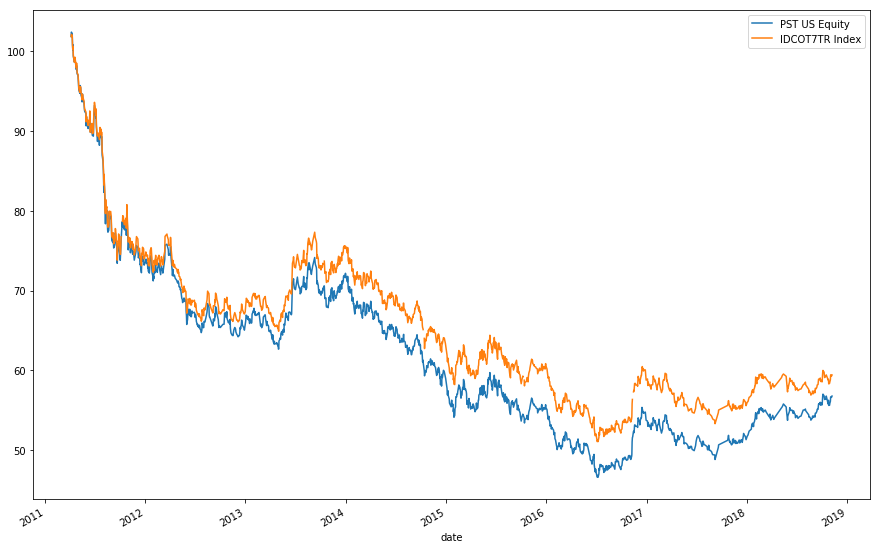

Leverage: -1


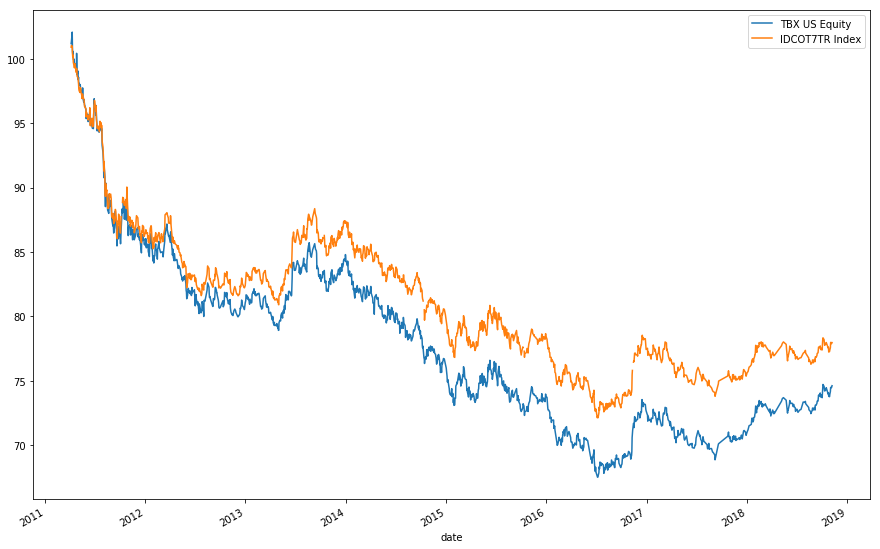

Leverage: 2


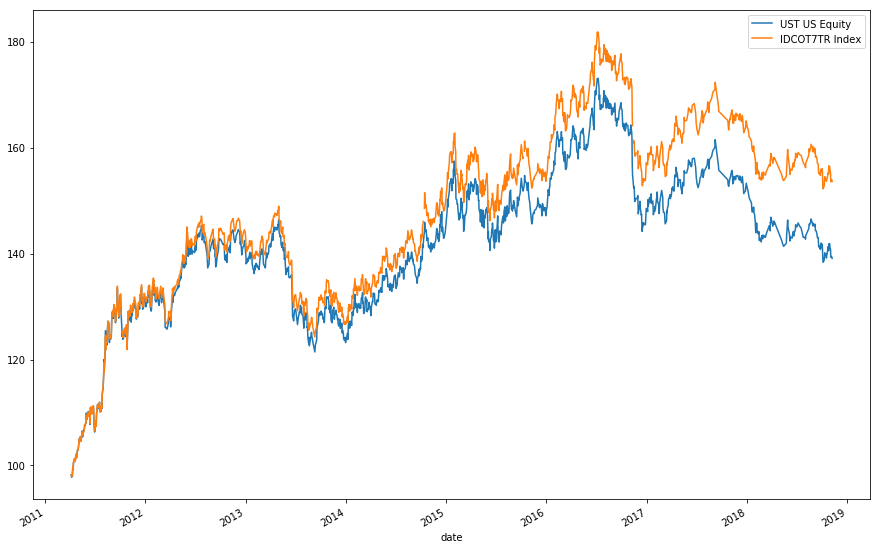

In [23]:
for i in levered_etfs_df.index:
    etf = levered_etfs_df.loc[i,'ETF']
    index = levered_etfs_df.loc[i,'Index']
    leverage = levered_etfs_df.loc[i,'Leverage']
    
    fig, ax = plt.subplots(nrows=1,ncols=1)
    
    (100*np.cumprod(1 + pdf_etf[etf].pct_change())).plot(ax=ax)
    
    (100*np.cumprod(1 + pdf_indices[index].pct_change()*leverage)).plot(ax=ax)
    ax.legend()
    ax.plot()
    
    print("Leverage: %i" % leverage)
    plt.show()

### Annual Returns

In [24]:
etf_ann_rdf = pd.DataFrame(
    index = pdf_etf[etf].resample('a').last().pct_change().index,
    columns = levered_etfs_df['ETF'].values
)

index_ann_rdf = pd.DataFrame(
    index = pdf_etf[etf].resample('a').last().pct_change().index,
    columns = levered_etfs_df['ETF'].values
)

for i in levered_etfs_df.index:
    etf = levered_etfs_df.loc[i,'ETF']
    index = levered_etfs_df.loc[i,'Index']
    leverage = levered_etfs_df.loc[i,'Leverage']
    
    etf_ann_rdf[etf] = pdf_etf[etf].resample('a').last().pct_change()
    temp_index = (100*np.cumprod(1 + pdf_indices[index].pct_change()*leverage))
    index_ann_rdf[etf] = temp_index.resample('a').last().pct_change()
    

The annual returns of Levered ETFs match match very closely to the annual returns of levered indices. You can see the beta is around 1 and is statistically significant.

Note: Interestingly the beta is also statistically significantly greater than 1 as well.

In [25]:
X = index_ann_rdf.dropna().values.flatten()
y = etf_ann_rdf.dropna().values.flatten()

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.307e+04
Date:                Thu, 08 Nov 2018   Prob (F-statistic):          6.80e-134
Time:                        11:28:06   Log-Likelihood:                 256.69
No. Observations:                 133   AIC:                            -511.4
Df Residuals:                     132   BIC:                            -508.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0422      0.009    114.336      0.000       1.024       1.060
==============================================================================
Omnibus:                       21.604   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.809
Skew:                          -0.815   Prob(JB):                     7.51e-08
Kurtosis:                       4.807   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Annual Returns')

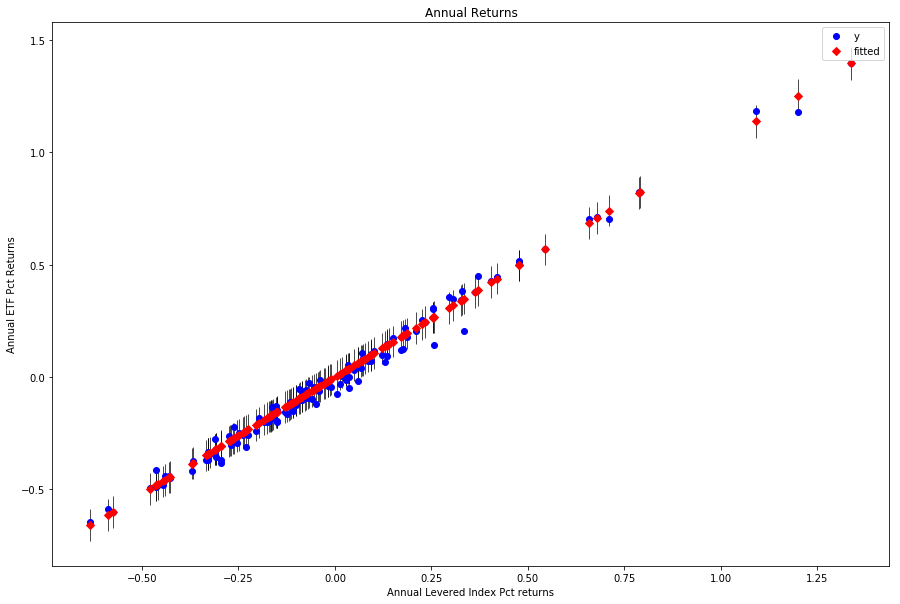

In [26]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model, 0, ax=ax)
ax.set_xlabel('Annual Levered Index Pct returns')
ax.set_ylabel('Annual ETF Pct Returns')
ax.set_title('Annual Returns')

### Daily Returns

In [27]:
X = levered_etfs_df['Index Percent Mean']*levered_etfs_df['Leverage']
y = levered_etfs_df['ETF Percent Mean']

model = sm.OLS(y, X).fit()
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ETF Percent Mean   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1161.
Date:                Thu, 08 Nov 2018   Prob (F-statistic):           8.40e-18
Time:                        11:28:06   Log-Likelihood:                 138.89
No. Observations:                  19   AIC:                            -275.8
Df Residuals:                      18   BIC:                            -274.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0577      0.031     34.078      0.000       0.992       1.123
==============================================================================
Omnibus:                        0.369   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.044
Skew:                          -0.114   Prob(JB):                        0.978
Kurtosis:                       2.943   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the OLS statistics above you can see that the Levered ETF daily returns has a coefficient of 1 to the Levered Index daily returns that is statistically significant.

Text(0.5,1,'Average Daily Returns')

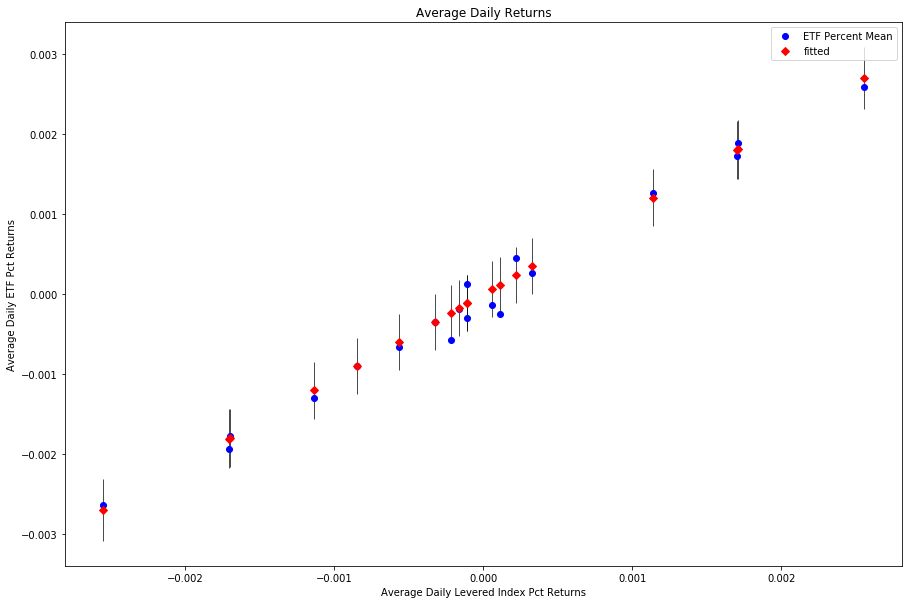

In [28]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model, 0, ax=ax)
ax.set_xlabel('Average Daily Levered Index Pct Returns')
ax.set_ylabel('Average Daily ETF Pct Returns')
ax.set_title('Average Daily Returns')

In [29]:
X = levered_etfs_df['Index Percent SD']*np.sqrt(np.power(levered_etfs_df['Leverage'],2))
y = levered_etfs_df['ETF Percent SD']

model = sm.OLS(y, X).fit()
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ETF Percent SD   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1337.
Date:                Thu, 08 Nov 2018   Prob (F-statistic):           2.40e-18
Time:                        11:28:06   Log-Likelihood:                 84.986
No. Observations:                  19   AIC:                            -168.0
Df Residuals:                      18   BIC:                            -167.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0577      0.029     36.570      0.000       0.997       1.118
==============================================================================
Omnibus:                        5.179   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                3.645
Skew:                           1.072   Prob(JB):                        0.162
Kurtosis:                       3.082   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard deviation is also as expected and the coefficient is also statistically significant.